In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset/data')

100%|██████████| 9.94G/9.94G [01:50<00:00, 96.8MB/s]


In [ ]:
IMG_SIZE = (224, 224)
def get_labels(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    auxiliary_label = parts[-2] == labels
    return  auxiliary_label
def decode_img(img):
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) / 255.0
    return img
def process_path(file_path):
    labels = get_labels(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, labels

In [ ]:
import os
import tensorflow as tf
labels= ['Both_smoke_and_fire','Smoke_from_fires', 'Fire_confounding_elements','Forested_areas_without_confounding_elements', 'Smoke_confounding_elements']

test_dir='the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/test'
test_dataset = tf.data.Dataset.list_files(str(test_dir + '/*/*/*'), shuffle=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test_dataset.batch(1)

In [ ]:
import numpy as np
vraiesclasses = []
for images,labels_ in test:
    for i in range(len(labels_)):
        vraiesclasses+=[np.flatnonzero(labels_[i] == True)[0] ]
vraies_classes=np.array(vraiesclasses)

In [ ]:
model_complexity=0
interpreter = tf.lite.Interpreter(model_path="model_fire.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
import numpy as np
output_data=[]
for input_data,labels in test:
  interpreter.invoke()
  interpreter.set_tensor(input_details[0]['index'], input_data)
  output_data += [interpreter.get_tensor(output_details[0]['index'])[0]]
output_data=np.array(np.argmax(output_data,axis=1))

In [ ]:
test = test.enumerate()
indices_class_0 = np.flatnonzero(output_data==0)
keys_tensor = tf.constant(indices_class_0)
vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0)  # If index not in table, return 0.


def hash_table_filter(index, value):
    table_value = table.lookup(index)  # 1 if index in arr, else 0.
    index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
    return index_in_arr

dataset_class_0 = test.filter(hash_table_filter)
dataset_class_0 = dataset_class_0.map(lambda idx,value: value)
dataset_class_0=reversed(list(dataset_class_0))

In [ ]:
indices_class_1 = np.flatnonzero(output_data==1)
keys_tensor = tf.constant(indices_class_1)
vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0)  # If index not in table, return 0.


def hash_table_filter(index, value):
    table_value = table.lookup( index)  # 1 if index in arr, else 0.
    index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
    return index_in_arr

dataset_class_1 = test.filter(hash_table_filter)
dataset_class_1 = dataset_class_1.map(lambda idx,value: value)
dataset_class_1=reversed(list(dataset_class_1))

In [ ]:
import numpy as np
model_complexity=0
interpreter1 = tf.lite.Interpreter(model_path="model_fire1.tflite")
interpreter1.allocate_tensors()

# Get input and output tensors.
input_details1 = interpreter1.get_input_details()
output_details1 = interpreter1.get_output_details()
output_data1=[]
labels_data1=[]
images1=[]
for input_data,labels_ in dataset_class_0:
  images1+=[input_data*255]
  interpreter1.invoke()
  input_data = np.float32(input_data)
  interpreter1.set_tensor(input_details1[0]['index'], input_data)
  output_data1 += [interpreter1.get_tensor(output_details1[0]['index'])[0]]
  labels_data1+=[np.flatnonzero(labels_ == True)[0]]

output_data1=np.array(np.argmax(output_data1,axis=-1))

In [ ]:
import numpy as np
model_complexity=0
interpreter2 = tf.lite.Interpreter(model_path="model_fire2.tflite")
interpreter2.allocate_tensors()

# Get input and output tensors.
input_details2 = interpreter2.get_input_details()
output_details2 = interpreter2.get_output_details()
output_data2=[]
labels_data2=[]
images2=[]
for input_data,labels_ in dataset_class_1:
  images2+=[input_data*255]
  interpreter2.invoke()
  input_data = np.float32(input_data)
  interpreter2.set_tensor(input_details2[0]['index'], input_data)
  output_data2 += [interpreter2.get_tensor(output_details2[0]['index'])[0]]
  labels_data2+=[np.flatnonzero(labels_ == True)[0]]
output_data2=np.array(np.argmax(output_data2,axis=-1))

In [ ]:
pred=np.concatenate([output_data1,(output_data2+2)])

In [ ]:
true_labels=np.concatenate([labels_data1,labels_data2])

In [ ]:
import random
image=images1+images2
images_pred = [(x, y) for x, y in zip(image, pred)]
random.shuffle(images_pred)

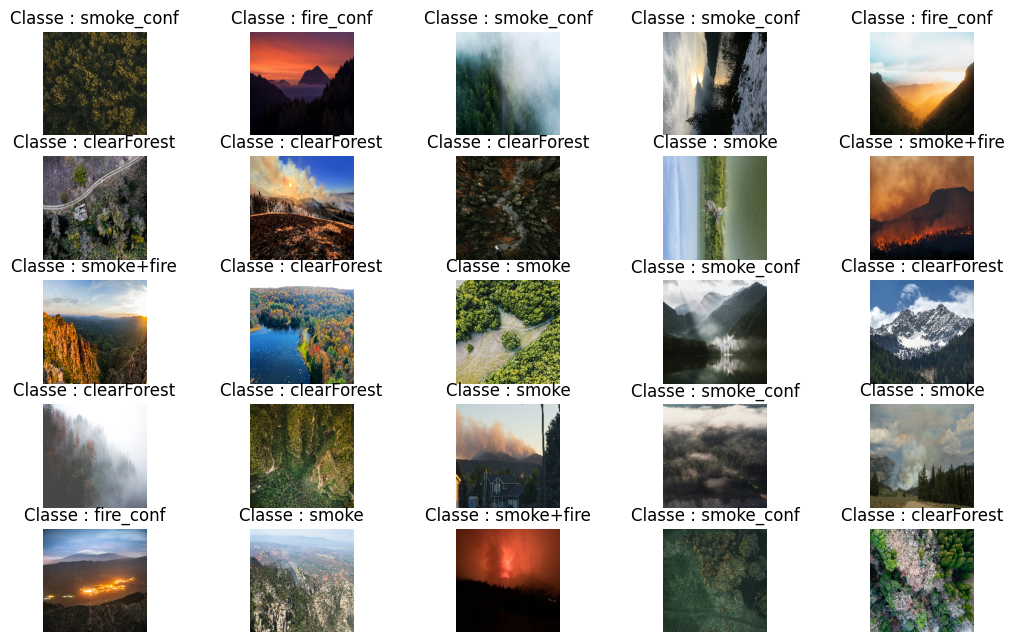

In [ ]:
import matplotlib.pyplot as plt

num_rows = 5
num_cols = 5
num_images = num_rows * num_cols
lab=["smoke+fire","smoke","fire_conf","clearForest","smoke_conf"]

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
i=0
for images, labels_ in images_pred:
    if i<num_images:
       ax = plt.subplot(num_rows, int(num_images/num_rows), i + 1)
       set_size(10,6)
       plt.imshow(images[0].numpy().astype('uint8'))
       plt.title(f'Classe : {lab[labels_]}')
       plt.axis("off")
       i+=1
    else :
      break


In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm_methode2 = confusion_matrix(true_labels, pred)
print("Matrice de confusion :")
print(cm_methode2)
cr_2 = classification_report(true_labels, pred)
print("Rapport de classification :")
print(cr_2)

Matrice de confusion :
[[42  7  3  2  5]
 [10 71  5  6  8]
 [ 2  2 41  2  5]
 [ 0  9  9 95 15]
 [ 2  6  7 10 46]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        59
           1       0.75      0.71      0.73       100
           2       0.63      0.79      0.70        52
           3       0.83      0.74      0.78       128
           4       0.58      0.65      0.61        71

    accuracy                           0.72       410
   macro avg       0.71      0.72      0.71       410
weighted avg       0.73      0.72      0.72       410



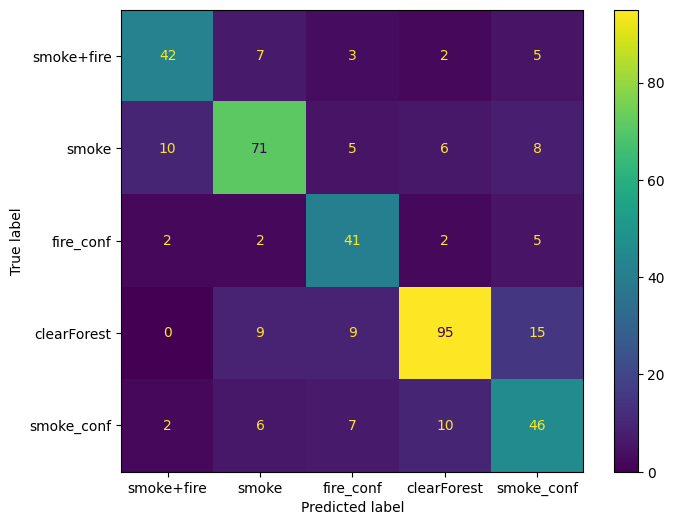

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
disp=ConfusionMatrixDisplay(cm_methode2,display_labels=["smoke+fire","smoke","fire_conf","clearForest","smoke_conf"])
disp.plot(ax=ax)
plt.show()

In [ ]:
def good_lab(x):
  if x==2:
    return 3
  if x==3:
    return 4
  if x==4:
    return 2
  else :
    return x


In [ ]:
import numpy as np
model_complexity=0
interpreter3 = tf.lite.Interpreter(model_path="model_tot.tflite")
interpreter3.allocate_tensors()
input_details3 = interpreter3.get_input_details()
output_details3 = interpreter3.get_output_details()
output_data3=[]
images3=[]
for input_data,labels in test_dataset:
  interpreter3.invoke()
  images3+=[input_data*255]
  input_data = np.float32(input_data)
  input_data=np.expand_dims(input_data,axis=0)
  interpreter3.set_tensor(input_details3[0]['index'], input_data)
  output_data3 += [interpreter3.get_tensor(output_details3[0]['index'])[0]]
output_data3=np.array(list(map(good_lab,np.argmax(output_data3,axis=-1))))

In [ ]:
images_pred1 = [(x, y) for x, y in zip(images3, output_data3)]
random.shuffle(images_pred1)

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm_1 = confusion_matrix(vraies_classes, output_data3)

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(cm_1)

# Afficher le rapport de classification
cr_1 = classification_report(vraies_classes, output_data3)
print("Rapport de classification :")
print(cr_1)

Matrice de confusion :
[[ 32   0   0  19   8]
 [ 78   0   0  13   9]
 [  4   0   0  25  23]
 [ 11   0   0 102  15]
 [ 47   0   0  17   7]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.19      0.54      0.28        59
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        52
           3       0.58      0.80      0.67       128
           4       0.11      0.10      0.11        71

    accuracy                           0.34       410
   macro avg       0.18      0.29      0.21       410
weighted avg       0.23      0.34      0.27       410



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


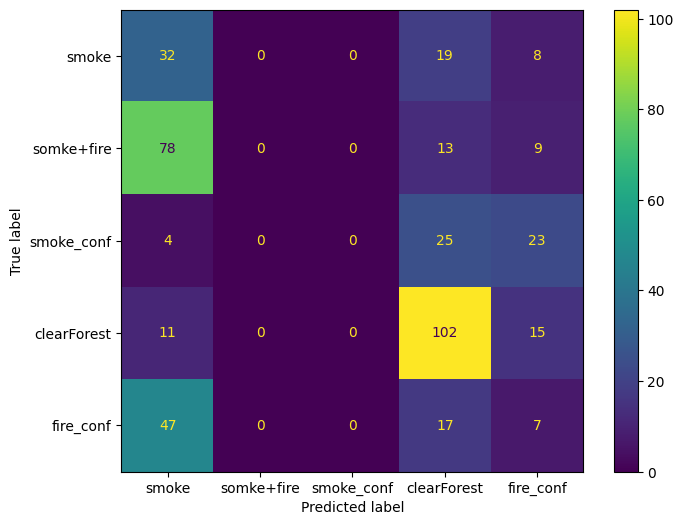

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
disp=ConfusionMatrixDisplay(cm_1,display_labels=["smoke","somke+fire","smoke_conf","clearForest","fire_conf"])
disp.plot(ax=ax)
plt.show()

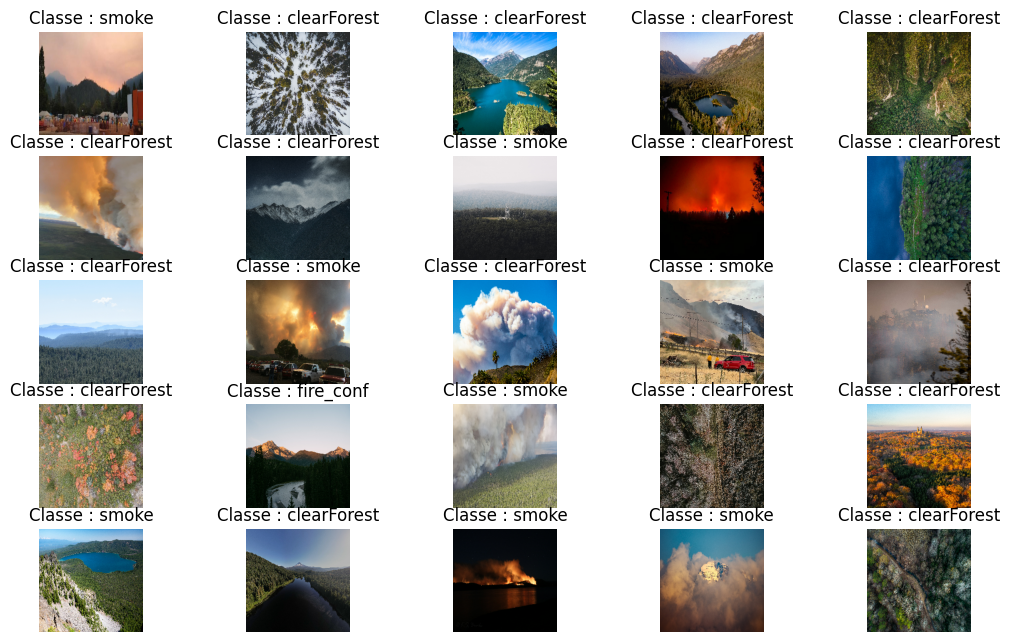

In [ ]:
met2=["smoke","somke+fire","smoke_conf","clearForest","fire_conf"]
i=0
for images, labels_ in images_pred1:
    if i<num_images:
       ax = plt.subplot(num_rows, int(num_images/num_rows), i + 1)
       set_size(10,6)
       plt.imshow(images.numpy().astype('uint8'))
       plt.title(f'Classe : {met2[labels_]}')
       plt.axis("off")
       i+=1
    else :
      break
